<a href="https://colab.research.google.com/github/un1qqe/Chat-Bot-NLG-Project-/blob/main/Chat_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-31 14:47:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-31 14:47:52 (24.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d hijest/cleaned-data-for-the-chatbot-collected-from-movies

 99% 303M/305M [00:03<00:00, 107MB/s] 
100% 305M/305M [00:03<00:00, 85.7MB/s]


In [ ]:
from helper_functions import unzip_data

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import re
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Concatenate
from keras.models import Model

In [ ]:
unzip_data("/content/cleaned-data-for-the-chatbot-collected-from-movies.zip")

In [ ]:
df= pd.read_csv('/content/dialogs_expanded.csv', index_col=False)
df.head()

,Unnamed: 0,question,answer,question_as_int,answer_as_int,question_len,answer_len
0,1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,"[54, 67, 74, 74, 12, 1, 40, 1, 82, 70, 77, 83,...","[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...",71,55
1,2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,"[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...","[46, 73, 63, 87, 14, 14, 14, 1, 82, 70, 67, 76...",55,73
2,3,You're asking me out. That's so cute. What's ...,Forget it.,"[56, 77, 83, 8, 80, 67, 1, 63, 81, 73, 71, 76,...","[37, 77, 80, 69, 67, 82, 1, 71, 82, 14]",62,10
3,4,"No, no, it's my fault -- we didn't have a prop...",Cameron.,"[45, 77, 12, 1, 76, 77, 12, 1, 71, 82, 8, 81, ...","[34, 63, 75, 67, 80, 77, 76, 14]",65,8
4,9,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.,"[38, 77, 81, 70, 12, 1, 71, 68, 1, 77, 76, 74,...","[43, 67, 82, 1, 75, 67, 1, 81, 67, 67, 1, 85, ...",46,25


In [ ]:
df.drop(['Unnamed: 0','question_as_int','answer_as_int','question_len','answer_len'],axis=1,inplace=True)

In [ ]:
print(df.shape)
print('='*60)
print(df.info)
print('='*60)
df.describe()

(139409, 2)
<bound method DataFrame.info of                                                  question  \
0       Well, I thought we'd start with pronunciation,...   
1       Not the hacking and gagging and spitting part....   
2       You're asking me out.  That's so cute. What's ...   
3       No, no, it's my fault -- we didn't have a prop...   
4          Gosh, if only we could find Kat a boyfriend...   
...                                                   ...   
139404    Well that one. The one who keeps looking at me.   
139405  Choose your targets men. That's right Watch th...   
139406  Colonel Durnford... William Vereker. I hear yo...   
139407                           Your orders, Mr Vereker?   
139408  I'm to take the Sikali with the main column to...   

                                                   answer  
0       Not the hacking and gagging and spitting part....  
1       Okay... then how 'bout we try out some French ...  
2                                          

,question,answer
count,139409,139409
unique,127480,127605
top,I don't know.,I don't know.
freq,203,276


In [ ]:
df.drop_duplicates(subset=['question'],inplace=True)
df.describe()

,question,answer
count,127480,127480
unique,127480,117520
top,"Well, I thought we'd start with pronunciation,...",I don't know.
freq,1,225


In [ ]:
print(df.isnull().sum())
print('\n')
print(df.isnull().any())

question    0
answer      0
dtype: int64


question    False
answer      False
dtype: bool


In [ ]:
df.loc[55:60,:]

,question,answer
55,No! You're not dating until your sister starts...,What if she never starts dating?
56,What if she never starts dating?,Then neither will you. And I'll get to sleep ...
57,Then neither will you. And I'll get to sleep ...,"But it's not fair -- she's a mutant, Daddy!"
58,But she doesn't want to date.,Exactly my point
59,"Daddy, I --",And where're you going?
60,And where're you going?,"If you must know, we were attempting to go to ..."


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def clean_text(text):
    text = text.lower()
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()])
    #  - ,$,#,%,&
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub('\n', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['encoder_input']=df['question'].apply(clean_text)
df['decoder_input']='<sos> '+df['answer'].apply(clean_text)
df['decoder_label']=df['answer'].apply(clean_text)+' eos>'
df.head()

,question,answer,encoder_input,decoder_input,decoder_label
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,well i thought we would start with pronunciati...,<sos> not the hacking and gagging and spitting...,not the hacking and gagging and spitting part ...
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,not the hacking and gagging and spitting part ...,<sos> okay then how bout we try out some frenc...,okay then how bout we try out some french cuis...
2,You're asking me out. That's so cute. What's ...,Forget it.,you are asking me out that is so cute what is ...,<sos> forget it,forget it eos>
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.,no no it is my fault we did not have a proper...,<sos> cameron,cameron eos>
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.,gosh if only we could find kat a boyfriend,<sos> let me see what i can do,let me see what i can do eos>


In [ ]:
encoder_input=np.array(df.question)
decoder_input=np.array(df.decoder_input)
decoder_label=np.array(df.decoder_label)

n_rows=df.shape[0]
print(f'{n_rows} rows')

indices=np.arange(n_rows)
np.random.shuffle(indices)

encoder_input=encoder_input[indices]
decoder_input=decoder_input[indices]
decoder_label=decoder_label[indices]

train_size=0.9
train_encoder_input=encoder_input[:int(n_rows*train_size)]
train_decoder_input=decoder_input[:int(n_rows*train_size)]
train_decoder_label=decoder_label[:int(n_rows*train_size)]

test_encoder_input=encoder_input[int(n_rows*train_size):]
test_decoder_input=decoder_input[int(n_rows*train_size):]
test_decoder_label=decoder_label[int(n_rows*train_size):]

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

127480 rows
(114732,)
(114732,)
(114732,)
(12748,)
(12748,)
(12748,)


In [ ]:
q_tok=Tokenizer()
q_tok.fit_on_texts(train_encoder_input)
print(len(q_tok.word_counts))

a_tok=Tokenizer()
a_tok.fit_on_texts(train_decoder_input)
a_tok.fit_on_texts(train_decoder_label)
print(len(a_tok.word_counts))

train_encoder_input=q_tok.texts_to_sequences(train_encoder_input)
test_encoder_input=q_tok.texts_to_sequences(test_encoder_input)

train_decoder_input=a_tok.texts_to_sequences(train_decoder_input)
test_decoder_input=a_tok.texts_to_sequences(test_decoder_input)
train_decoder_label=a_tok.texts_to_sequences(train_decoder_label)
test_decoder_label=a_tok.texts_to_sequences(test_decoder_label)

question_word_size=len(q_tok.word_counts)
question_vocab_size=question_word_size+1
answer_word_size=len(a_tok.word_counts)
answer_vocab_size=answer_word_size+1

29984
30563


maximum question sequence length >> 25
maximum question sequence length >> 28


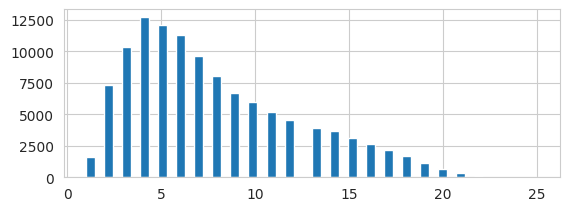

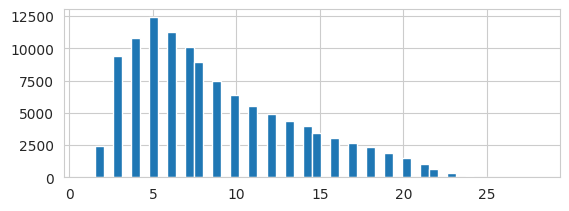

In [ ]:
question_lengths=[len(s) for s in train_encoder_input]
print(f'maximum question sequence length >> {np.max(question_lengths)}')

answer_lengths=[len(s) for s in train_decoder_input]
print(f'maximum question sequence length >> {np.max(answer_lengths)}')

plt.subplot(2,1,1)
plt.hist(question_lengths,bins=50)
plt.show()

plt.subplot(2,1,2)
plt.hist(answer_lengths,bins=50)
plt.show()

In [ ]:

train_encoder_input=pad_sequences(train_encoder_input,padding='post')
train_decoder_input=pad_sequences(train_decoder_input,padding='post')
train_decoder_label=pad_sequences(train_decoder_label,padding='post')

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

question_sequence_size=train_encoder_input.shape[1]
answer_sequence_size=train_decoder_input.shape[1]

test_encoder_input=pad_sequences(test_encoder_input,padding='post',maxlen=question_sequence_size)
test_decoder_input=pad_sequences(test_decoder_input,padding='post',maxlen=answer_sequence_size)
test_decoder_label=pad_sequences(test_decoder_label,padding='post',maxlen=answer_sequence_size)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

(114732, 25)
(114732, 28)
(114732, 28)
(12748, 25)
(12748, 28)
(12748, 28)


In [ ]:
train_encoder_input

array([[  84,   51, 2702, ...,    0,    0,    0],
       [  27,  220,   39, ...,    0,    0,    0],
       [  50,    1,  216, ...,    0,    0,    0],
       ...,
       [   6,   11,    4, ...,    0,    0,    0],
       [   1,   22,    6, ...,    0,    0,    0],
       [  25,    2,   49, ...,    0,    0,    0]], dtype=int32)

In [ ]:
!kaggle datasets download -d watts2/glove6b50dtxt

 90% 61.0M/67.7M [00:00<00:00, 138MB/s]
100% 67.7M/67.7M [00:00<00:00, 126MB/s]


In [ ]:
unzip_data('/content/glove6b50dtxt.zip')

In [ ]:
embedding_dict=dict()

f=open(os.path.join('/content/glove.6B.50d.txt'),encoding='utf-8')

for line in f:
  tokens=line.split()
  word=tokens[0]
  vector=tokens[1:]
  vector=np.asarray(vector,dtype='float32')
  embedding_dict[word]=vector

f.close()

In [ ]:
embedding_size=len(embedding_dict['world'])
question_embedding_matrix=np.zeros((question_vocab_size,embedding_size))
for word,idx in q_tok.word_index.items():
  if idx <= question_word_size:
    vector=embedding_dict.get(word)
    if vector is not None:
      question_embedding_matrix[idx]=np.asarray(vector,dtype='float32')


In [ ]:
answer_embedding_matrix=np.zeros((answer_vocab_size,embedding_size))
for word,idx in q_tok.word_index.items():
  if idx<=answer_word_size:
    vector=embedding_dict.get(word)
    if vector is not None:
      answer_embedding_matrix[idx]=np.asarray(vector,dtype='float32')


In [ ]:
print(f'There are {len(embedding_dict)} embedding vectors in total')
print(f'The size of embedding vector here >> {embedding_size}')

There are 400000 embedding vectors in total
The size of embedding vector here >> 50


In [ ]:
def seq2question(encoder_input):
  ret=[q_tok.index_word[idx] for idx in encoder_input if idx != 0]
  return ' '.join(ret)

In [ ]:
def seq2answer(decoder_input):
  ret=[]
  for idx in decoder_input:
    if idx!=0:
      if a_tok.index_word[idx]!='sos' and a_tok.index_word[idx]!='eos':
        ret.append(a_tok.index_word[idx])
  return ' '.join(ret)


In [ ]:
import tensorflow
from tensorflow.keras.layers import Attention

In [ ]:
question_sequence_size

25

In [ ]:
hidden_size=256

encoder_input=Input(shape=[question_sequence_size])

encoder_embedding=Embedding(question_vocab_size,embedding_size,mask_zero=True,trainable=True,weights=[question_embedding_matrix])
encoder_embedded=encoder_embedding(encoder_input)
lstm1=Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output1,_,_,_,_=lstm1(encoder_embedded)

lstm2=Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output2,_,_,_,_=lstm2(encoder_output1)

lstm3=Bidirectional(LSTM(128,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output3,encoder_forward_h3,encoder_forward_c3,encoder_backward_h3,encoder_backward_c3=lstm3(encoder_output2)

encoder_h3=Concatenate()([encoder_forward_h3,encoder_backward_h3])
encoder_dense_h=Dense(hidden_size)
encoder_h3=encoder_dense_h(encoder_h3)

encoder_c3=Concatenate()([encoder_forward_c3,encoder_backward_c3])
encoder_dense_c=Dense(hidden_size)
encoder_c3=encoder_dense_c(encoder_c3)

gen_encoder=Model(encoder_input,[encoder_h3,encoder_c3])


In [ ]:
gen_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 25, 50)               1499250   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  [(None, 25, 512),            628736    ['embedding[0][0]']           
 al)                          (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                    

In [ ]:
from keras.utils import plot_model

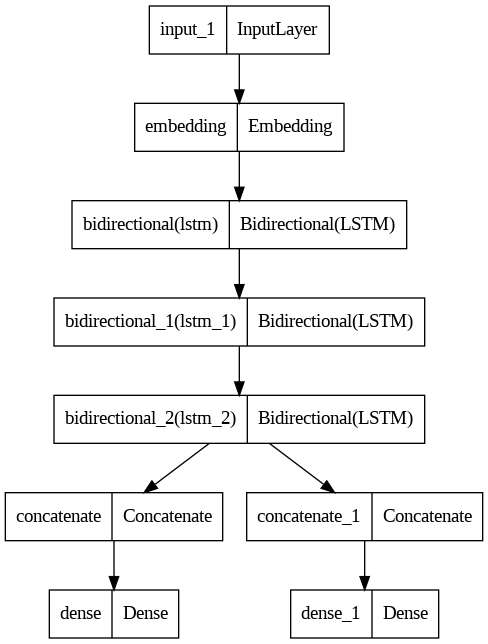

In [ ]:
plot_model(gen_encoder)

In [ ]:
decoder_input=Input(shape=(None,))
decoder_embedding=Embedding(answer_vocab_size,embedding_size,mask_zero=True,trainable=True,weights=[answer_embedding_matrix])
decoder_embedded=decoder_embedding(decoder_input)

decoder_lstm=LSTM(hidden_size,return_sequences=True,return_state=True)
decoder_output,_,_=decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])
print(decoder_output)
print(encoder_output3)
attn_layer=Attention()
attention_context=attn_layer([decoder_output,encoder_output3])
decoder_output=Concatenate()([decoder_output,attention_context])

dense1=Dense(512,activation='relu')
decoder_output=dense1(decoder_output)
decoder_softmax=Dense(answer_vocab_size,activation='softmax')
decoder_output=decoder_softmax(decoder_output)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 256), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:1', description="created by layer 'lstm_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 25, 256), dtype=tf.float32, name=None), name='bidirectional_2/concat:0', description="created by layer 'bidirectional_2'")


In [ ]:
trainer=Model([encoder_input,decoder_input],decoder_output)
loss=tensorflow.keras.losses.SparseCategoricalCrossentropy()
trainer.compile(loss=loss,metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())
trainer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 25, 50)               1499250   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  [(None, 25, 512),            628736    ['embedding[0][0]']           
 al)                          (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                  

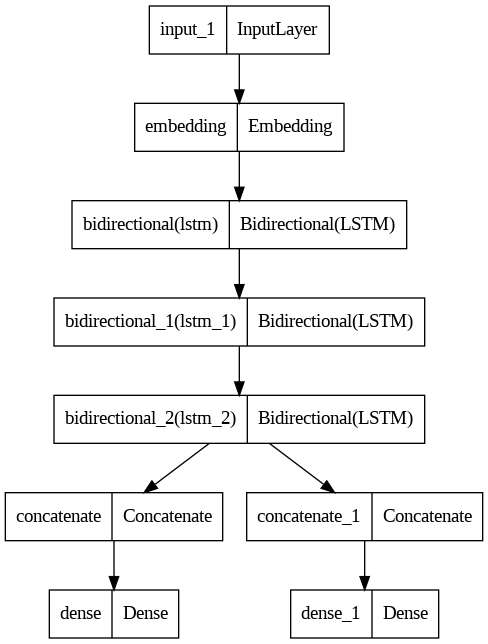

In [ ]:
gen_encoder=Model(encoder_input,[encoder_output3,encoder_h3,encoder_c3])

gen_decoder_value_input=Input(shape=(question_sequence_size,hidden_size))
gen_decoder_h_input=Input(shape=[hidden_size])
gen_decoder_c_input=Input(shape=[hidden_size])

gen_decoder_embedded=decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c=decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])
gen_attention_context=attn_layer([gen_decoder_output,gen_decoder_value_input])

gen_decoder_output=Concatenate()([gen_decoder_output,gen_attention_context])

gen_decoder_output=dense1(gen_decoder_output)
gen_decoder_output=decoder_softmax(gen_decoder_output)

gen_decoder=Model([decoder_input]+[gen_decoder_value_input,gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])
plot_model(gen_encoder)

In [ ]:
train_hist=trainer.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=20,validation_split=0.3,batch_size=512)


Epoch 1/20
157/157 [==============================] - 182s 1s/step - loss: 5.4877 - accuracy: 0.1583 - val_loss: 5.3834 - val_accuracy: 0.1780
Epoch 2/20
157/157 [==============================] - 176s 1s/step - loss: 5.1611 - accuracy: 0.1908 - val_loss: 5.2000 - val_accuracy: 0.1994
Epoch 3/20
157/157 [==============================] - 173s 1s/step - loss: 4.9714 - accuracy: 0.2060 - val_loss: 5.1033 - val_accuracy: 0.2102
Epoch 4/20
157/157 [==============================] - 174s 1s/step - loss: 4.8404 - accuracy: 0.2138 - val_loss: 5.0536 - val_accuracy: 0.2161
Epoch 5/20
157/157 [==============================] - 173s 1s/step - loss: 4.7330 - accuracy: 0.2201 - val_loss: 5.0121 - val_accuracy: 0.2216
Epoch 6/20
157/157 [==============================] - 173s 1s/step - loss: 4.6372 - accuracy: 0.2245 - val_loss: 4.9934 - val_accuracy: 0.2248
Epoch 7/20
157/157 [==============================] - 173s 1s/step - loss: 4.5489 - accuracy: 0.2282 - val_loss: 5.0018 - val_accuracy: 0.2271

In [ ]:
 loaded_model = tf.keras.saving.load_model('/content/drive/MyDrive/first_chat_bot.h5')

In [ ]:
def generate_from_input(encoder_input):
    #             [1,2,3]
    values,h,c = gen_encoder.predict(encoder_input)
    decoder_seq = np.zeros((1,1))
    # sos:1
    decoder_seq[0,0] = a_tok.word_index['sos']

    generated_sent = ''
    stop_condition= False

    while not stop_condition:
        output,h_state,c_state = gen_decoder.predict([decoder_seq]+[values,h,c])
        sampled_index = np.argmax(output[0,-1,:])
        # output :am , output :I
        sampled_word = a_tok.index_word[sampled_index]

        if sampled_word != 'eos':
            generated_sent = generated_sent + sampled_word + ' '

        if sampled_word == 'eos' or len(generated_sent) >= answer_sequence_size:
            stop_condition=True

        decoder_seq = np.zeros((1,1))
        decoder_seq[0,0] = sampled_index
        h,c = h_state,c_state
        # Remove spaces at the beginning
    return generated_sent.strip()

In [ ]:
#results on train dataset
sample_indices= [5,26,7,11,735,662,115,321]

for idx in sample_indices:
    generated_sent = generate_from_input(train_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(train_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(train_decoder_input[idx])}")
    print("="*45)
    print("\n")

1/1 [==============================] - 0s 23ms/step
Question >> it turned up on the black market one of my sources thought i might be interested
Answer(Generated) >> i do not know
Answer(Label) >> i do not know what to say


1/1 [==============================] - 0s 21ms/step
Question >> what do you mean you decided not to park here
Answer(Generated) >> i am not sure
Answer(Label) >> yeah i just came in i decided not to park here


1/1 [==============================] - 0s 21ms/step
Question >> is this it this is it right
Answer(Generated) >> i am not sure
Answer(Label) >> slow down you cannot just take the book like that


1/1 [==============================] - 0s 23ms/step
Question >> no we won't momma i'll just have them call and tell patrick it's us
Answer(Generated) >> i am not sure i am not
Answer(Label) >> girl they build gates like that to keep people like us out


1/1 [==============================] - 0s 22ms/step
Question >> remark
Answer(Generated) >> you are not a cup of c

In [ ]:
#results on test dataset
sample_indices= [100,20,44,33]

for idx in sample_indices:
    generated_sent = generate_from_input(test_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(test_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(test_decoder_input[idx])}")
    print("="*45)
    print("\n")

1/1 [==============================] - 0s 23ms/step
Question >> you know and all that
Answer(Generated) >> i am not a friend of my life
Answer(Label) >> but he said he died


1/1 [==============================] - 0s 23ms/step
Question >> how'd you know my name was jack
Answer(Generated) >> i do not know
Answer(Label) >> i call all you white guys jack


1/1 [==============================] - 0s 23ms/step
Question >> well you can try talking them into that if
Answer(Generated) >> i am not a bad person
Answer(Label) >> i have enough with me to put him out and i think i know a way to


1/1 [==============================] - 0s 24ms/step
Question >> so have you thought anymore about dartmouth
Answer(Generated) >> i am not a bad person
Answer(Label) >> yeah i have


